In [1]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
from keras_preprocessing.image import ImageDataGenerator
from PIL import Image
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4701205933082723119
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15866894784808640833
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6579684390
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16763428424625635191
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:27:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 10509067798043107806
physical_device_desc: "device: XLA_GPU device"
]


# Data preparation

In [3]:
images = list(Path(os.path.join('../data/unet/lung_segmentation/CXR_png/img')).glob('**/*'))
masks = list(Path(os.path.join('../data/unet/lung_segmentation/masks/img')).glob('**/*'))

In [4]:
print("Amount of images: ", len(images))
print("Amount of masks: ", len(masks))

Amount of images:  800
Amount of masks:  704


In [5]:
img_mask_tuples = []

for mask_path in masks:
    for i in images:
        basename = (os.path.basename(i)).split(".")[0]
        if basename in str(mask_path):
            img_path = i
            break
    img_mask_tuples.append((str(img_path), str(mask_path)))

In [6]:
len(img_mask_tuples)

704

## Plot images and masks

In [7]:
def plot_img(img_mask_tuple):
    img_concat = np.concatenate((cv2.imread(str(img_mask_tuple[0])), cv2.imread(str(img_mask_tuple[1]))), axis=1)
    plt.axis('off')
    plt.imshow(img_concat)

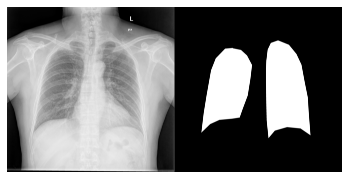

In [8]:
plot_img(img_mask_tuples[1])

In [9]:
def plot_img_matrix(img_mask_tuple_list, cols):
    # concat
    images = []
    for t in img_mask_tuple_list:
        img_concat = np.concatenate((cv2.imread(str(t[0])), cv2.imread(str(t[1]))), axis=1)
        images.append(img_concat)
    # plot
    plt.subplots(figsize=(15,5))
    if len(images) % cols == 0:
        rows = len(images) / cols
    else:
        rows = (len(images) % cols) +1
    for num, x in enumerate(images):
        plt.subplot(rows,cols,num+1)
        plt.axis('off')
        plt.imshow(x)

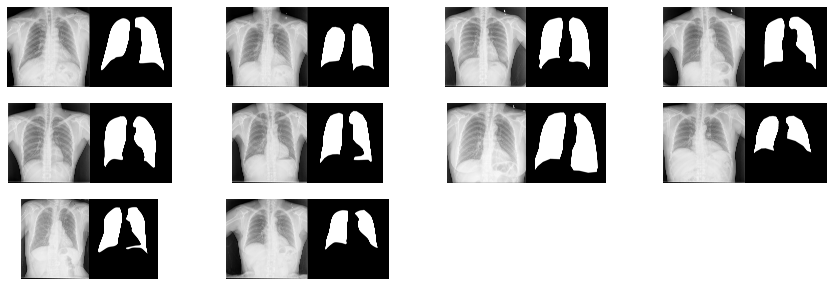

In [10]:
plot_img_matrix(img_mask_tuples[:10], 4)

## Train-Validation split

In [11]:
df = pd.DataFrame(img_mask_tuples, dtype='str', columns=['img', 'mask'])
train = df.sample(frac=0.8, random_state=200)
test = df.drop(train.index)

In [12]:
test.head()

,img,mask
0,..\data\unet\lung_segmentation\CXR_png\img\CHN...,..\data\unet\lung_segmentation\masks\img\CHNCX...
2,..\data\unet\lung_segmentation\CXR_png\img\CHN...,..\data\unet\lung_segmentation\masks\img\CHNCX...
6,..\data\unet\lung_segmentation\CXR_png\img\CHN...,..\data\unet\lung_segmentation\masks\img\CHNCX...
7,..\data\unet\lung_segmentation\CXR_png\img\CHN...,..\data\unet\lung_segmentation\masks\img\CHNCX...
17,..\data\unet\lung_segmentation\CXR_png\img\CHN...,..\data\unet\lung_segmentation\masks\img\CHNCX...


## UNET

In [13]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator()

img_generator = train_datagen.flow_from_dataframe(
    dataframe= pd.DataFrame(train['img']), # images
    directory=None,
    x_col="img",
    target_size=(256, 256),
    class_mode=None,
    batch_size=32
)
mask_generator = train_datagen.flow_from_dataframe(
    dataframe= pd.DataFrame(train['mask']), # masks
    directory=None,
    x_col="mask",
    target_size=(256, 256),
    class_mode=None,
    batch_size=32
)

val_img_generator = val_datagen.flow_from_dataframe(
    dataframe= pd.DataFrame(test['img']), # images
    directory=None,
    x_col="img",
    target_size=(256, 256),
    class_mode=None,
    batch_size=32
)
val_mask_generator = val_datagen.flow_from_dataframe(
    dataframe= pd.DataFrame(test['mask']), # masks
    directory=None,
    x_col="mask",
    target_size=(256, 256),
    class_mode=None,
    batch_size=32
)

#img_generator = train_datagen.flow_from_directory(
#    "../data/unet/lung_segmentation/CXR_png/",
#     class_mode=None,
#    batch_size=32
#)
#mask_generator = train_datagen.flow_from_directory(
#    "../data/unet/lung_segmentation/masks/",
#    class_mode=None,
#    batch_size=32
#)

train_generator = zip(img_generator, mask_generator)
val_generator = zip(val_img_generator, val_mask_generator)

Found 563 validated image filenames.
Found 563 validated image filenames.
Found 141 validated image filenames.
Found 141 validated image filenames.


In [14]:
model = sm.Unet()
model.compile(
    'Adam',
    loss=sm.losses.bce_jaccard_loss,
    metrics=[sm.metrics.iou_score],
)
# model.summary()

In [18]:
history = model.fit(train_generator, 
                    # validation_data=val_generator,
                    # steps_per_epoch=32, 
                    validation_steps=32,
                    epochs=5,
                    batch_size=32)

Epoch 1/5
32/32 [==============================] - ETA: 0s - loss: 0.6609 - iou_score: 0.6019

KeyboardInterrupt: 